### Постановка задачи

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 5 дней после окончания последнего вебинара.
Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества.
Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

### Примерное описание этапов выполнения курсового проекта<a class="anchor" id="course_project_steps"></a>

**Построение модели классификации**
1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

### Обзор данных<a class="anchor" id="course_project_review"></a>

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - кредитный рейтинг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [1]:
import pandas as pd
import numpy as np
import pickle
import random

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgbm, catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [4]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [5]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [6]:
train = r'C:\Users\Мила\Documents\Библиотеки Python для Data Science продолжение\course_project\course_project_train.csv'
test = r'C:\Users\Мила\Documents\Библиотеки Python для Data Science продолжение\course_project\course_project_test.csv'

In [7]:
df_train= pd.read_csv(train)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [8]:
df_train.shape

(7500, 17)

In [9]:
df_test= pd.read_csv(test)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [10]:
df_test.shape

(2500, 16)

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7

In [12]:
df_train.isnull().sum()/df_train.shape[0]*100

Home Ownership                   0.000000
Annual Income                   20.760000
Years in current job             4.946667
Tax Liens                        0.000000
Number of Open Accounts          0.000000
Years of Credit History          0.000000
Maximum Open Credit              0.000000
Number of Credit Problems        0.000000
Months since last delinquent    54.413333
Bankruptcies                     0.186667
Purpose                          0.000000
Term                             0.000000
Current Loan Amount              0.000000
Current Credit Balance           0.000000
Monthly Debt                     0.000000
Credit Score                    20.760000
Credit Default                   0.000000
dtype: float64

In [13]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
Home Ownership                  2500 non-null object
Annual Income                   1987 non-null float64
Years in current job            2414 non-null object
Tax Liens                       2500 non-null float64
Number of Open Accounts         2500 non-null float64
Years of Credit History         2500 non-null float64
Maximum Open Credit             2500 non-null float64
Number of Credit Problems       2500 non-null float64
Months since last delinquent    1142 non-null float64
Bankruptcies                    2497 non-null float64
Purpose                         2500 non-null object
Term                            2500 non-null object
Current Loan Amount             2500 non-null float64
Current Credit Balance          2500 non-null float64
Monthly Debt                    2500 non-null float64
Credit Score                    1987 non-null float64
dtypes: float64(12), object(4)
me

In [14]:
df_test.isnull().sum()/df_train.shape[0]*100

Home Ownership                   0.000000
Annual Income                    6.840000
Years in current job             1.146667
Tax Liens                        0.000000
Number of Open Accounts          0.000000
Years of Credit History          0.000000
Maximum Open Credit              0.000000
Number of Credit Problems        0.000000
Months since last delinquent    18.106667
Bankruptcies                     0.040000
Purpose                          0.000000
Term                             0.000000
Current Loan Amount              0.000000
Current Credit Balance           0.000000
Monthly Debt                     0.000000
Credit Score                     6.840000
dtype: float64

**Обзор целевой переменной**

In [15]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [16]:
df_train.groupby('Credit Default').apply(lambda x : x .median())

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
Credit Default,,,,,,,,,,,,,
0,1225747.0,0.0,10.0,17.1,493746.0,0.0,32.0,0.0,314534.0,209285.0,15939.0,732.0,0.0
1,1055915.5,0.0,11.0,16.7,442090.0,0.0,33.0,0.0,290576.0,210102.0,16390.0,730.5,1.0


In [17]:
df_train.groupby('Credit Default').apply(lambda x : x .mean())

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
Credit Default,,,,,,,,,,,,,
0,1.418047e+06,0.025988,11.042138,18.408168,1.088422e+06,0.163727,34.656814,0.116794,1.640219e+07,293719.423427,18176.425469,723.577885,0.0
1,1.224243e+06,0.040700,11.357312,18.086228,5.798982e+05,0.185991,34.781282,0.118065,3.266510e+05,279925.570279,18666.352106,2327.548611,1.0


можно в некоторых параметрах увидеть большое различие мезду средней и медианой, значит есть выбросы

**Обзор номинативных признаков**

In [18]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

In [19]:
for cat_colname in df_test.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_test[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    1225
Rent             1020
Own Home          248
Have Mortgage       7
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    810
3 years      228
2 years      212
< 1 year     207
5 years      169
1 year       153
4 years      152
7 years      140
6 years      137
8 years      107
9 years       99
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      1973
other                    240
home improvements        140
buy a car                 34
business loan             30
medical bills             27
buy house                 19
take a trip               14
major purchase             9
small business             5
educational expenses       3
vacation                   3
wedding                    2
moving               

In [20]:
df_train.groupby(['Purpose'])['Credit Default'].value_counts(normalize=True)

Purpose               Credit Default
business loan         0                 0.573643
                      1                 0.426357
buy a car             0                 0.750000
                      1                 0.250000
buy house             0                 0.735294
                      1                 0.264706
debt consolidation    0                 0.721736
                      1                 0.278264
educational expenses  0                 0.900000
                      1                 0.100000
home improvements     0                 0.737864
                      1                 0.262136
major purchase        0                 0.775000
                      1                 0.225000
medical bills         0                 0.690141
                      1                 0.309859
moving                0                 0.818182
                      1                 0.181818
other                 0                 0.703759
                      1         

In [21]:
df_train.groupby(['Bankruptcies'])['Credit Default'].value_counts(normalize=True)


Bankruptcies  Credit Default
0.0           0                 0.718018
              1                 0.281982
1.0           0                 0.723919
              1                 0.276081
2.0           0                 0.645161
              1                 0.354839
3.0           0                 0.714286
              1                 0.285714
4.0           0                 0.500000
              1                 0.500000
Name: Credit Default, dtype: float64

In [22]:
df_train.groupby(['Number of Credit Problems'])['Credit Default'].value_counts(normalize=True)

Number of Credit Problems  Credit Default
0.0                        0                 0.719431
                           1                 0.280569
1.0                        0                 0.726757
                           1                 0.273243
2.0                        0                 0.645161
                           1                 0.354839
3.0                        0                 0.600000
                           1                 0.400000
4.0                        1                 0.666667
                           0                 0.333333
5.0                        1                 0.571429
                           0                 0.428571
6.0                        0                 1.000000
7.0                        0                 1.000000
Name: Credit Default, dtype: float64

**Обзор количественных признаков**

In [23]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [24]:
df_test.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,1.987000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,1142.000000,2497.000000,2.500000e+03,2.500000e+03,2500.000000,1987.000000
mean,1.366922e+06,0.035200,11.184400,18.325920,7.105704e+05,0.162000,34.181261,0.106928,1.215572e+07,2.963966e+05,18271.340000,1234.516860
std,9.171252e+05,0.386291,4.852774,7.254659,1.511983e+06,0.559894,22.024277,0.357189,3.226097e+07,3.783020e+05,11543.881469,1740.219442
min,1.065330e+05,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,1.542200e+04,0.000000e+00,93.000000,585.000000
25%,8.523115e+05,0.000000,8.000000,13.400000,2.785860e+05,0.000000,16.000000,0.000000,1.871265e+05,1.101145e+05,10024.750000,710.000000
50%,1.178475e+06,0.000000,10.000000,17.000000,4.786760e+05,0.000000,30.000000,0.000000,3.223660e+05,2.073850e+05,16642.500000,731.000000
75%,1.629734e+06,0.000000,14.000000,22.100000,8.025985e+05,0.000000,50.000000,0.000000,5.225825e+05,3.663485e+05,24146.000000,743.000000
max,1.497561e+07,15.000000,48.000000,53.400000,5.448439e+07,15.000000,82.000000,5.000000,1.000000e+08,6.030087e+06,93555.000000,7480.000000


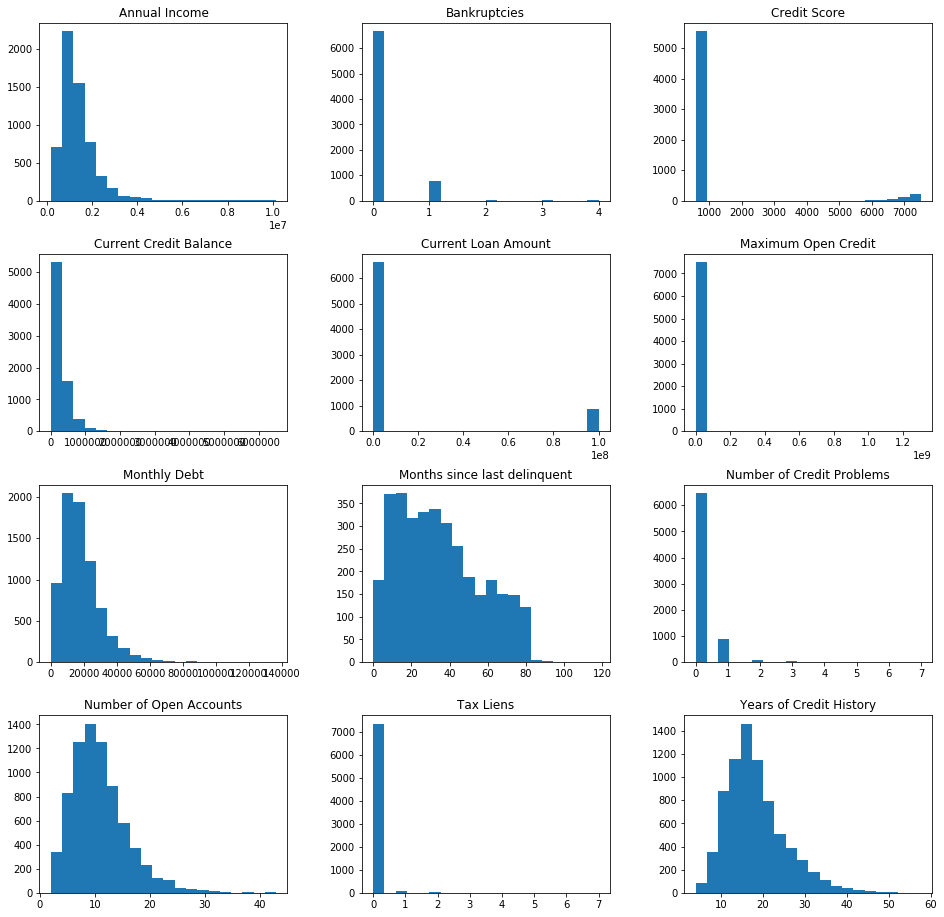

In [25]:
df_num_features = df_train.select_dtypes(include=['float64', 'float32'])
df_num_features.hist(figsize=(16,16), bins=20, grid=False);

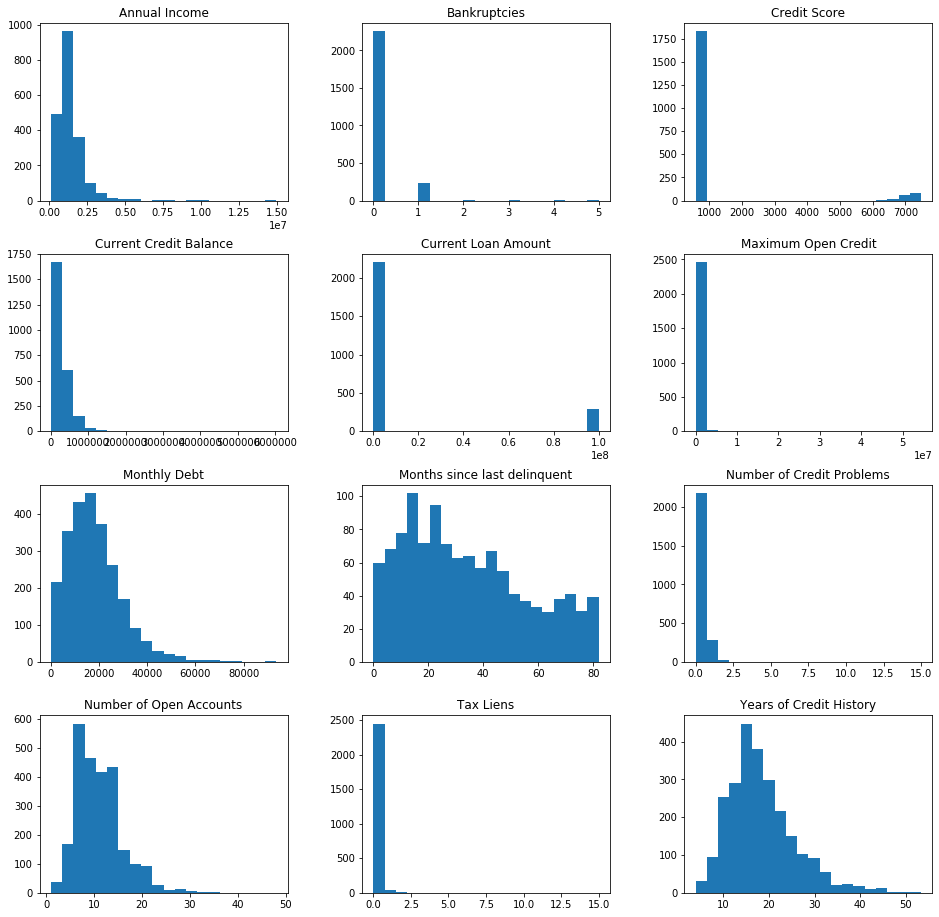

In [26]:
df_num_features = df_test.select_dtypes(include=['float64', 'float32'])
df_num_features.hist(figsize=(16,16), bins=20, grid=False);

In [27]:
df_train['Tax Liens'].value_counts().sort_values()

7.0       1
5.0       2
6.0       2
4.0       6
3.0      10
2.0      30
1.0      83
0.0    7366
Name: Tax Liens, dtype: int64

In [28]:
df_train['Bankruptcies'].value_counts().sort_values()

4.0       2
3.0       7
2.0      31
1.0     786
0.0    6660
Name: Bankruptcies, dtype: int64

In [29]:
df_train['Number of Credit Problems'].value_counts().sort_values()

7.0       1
6.0       4
5.0       7
4.0       9
3.0      35
2.0      93
1.0     882
0.0    6469
Name: Number of Credit Problems, dtype: int64

In [30]:
df_train['Current Loan Amount'].value_counts().sort_values()

264616.0        1
186846.0        1
367334.0        1
290642.0        1
200640.0        1
             ... 
270226.0        5
216106.0        5
218064.0        6
89298.0         6
99999999.0    870
Name: Current Loan Amount, Length: 5386, dtype: int64

In [31]:
df_train['Annual Income'][df_train ['Annual Income']>= 6000000].count()

26

In [32]:
df_train['Annual Income'][df_train ['Annual Income']>= 6000000].count()/df_train.shape[0]*100

0.3466666666666667

In [33]:
df_train['Current Credit Balance'][df_train ['Current Credit Balance']>= 1000000].count()/df_train.shape[0]*100

2.506666666666667

In [34]:
df_train['Maximum Open Credit'][df_train ['Maximum Open Credit']> 10000000].count()/df_train.shape[0]*100

0.2533333333333333

при обработке уберем эти выбросы 

### Обработка выбросов и Построение новых признаков

In [35]:
class FeatureImputer:
    """Заполнение пропусков, обработка выбросов, создание новых фичей"""
    
    def __init__(self):
        self.medians=None
        
    def fit(self, df):
        self.medians = df.median()
    
    def transform(self, df):
        
        # Объединение Home Mortgage и Have Mortgage 
        df['Home Ownership'] = df['Home Ownership'].map({
                                                    'Home Mortgage':'Home Mortgage', 
                                                    'Have Mortgage':'Home Mortgage',
                                                    'Rent':'Rent',
                                                    'Own Home':'Own Home'}).astype(str)

        
        # Заполнение пропусков Years in current job модой
        df.loc[df['Years in current job'].isna(), 'Years in current job'] = df['Years in current job'].mode()[0]
         
        # Объединение Years in current job в группы
        df['Years in current job New_int'] = df['Years in current job'].map({
                                                    '< 1 year':'0',
                                                    '1 year':'1',
                                                    '2 years':'2',
                                                    '3 years':'3',
                                                    '4 years':'4',
                                                    '5 years':'5',
                                                    '6 years':'6',
                                                    '7 years':'7',
                                                    '8 years':'8',
                                                    '9 years':'9',
                                                    '10+ years':'10'}).astype(int)
#         
        # Объединим некоторые параметры в поле 'Years in current job'
#         df.loc[df['Years in current job'].isin(['1 year','4 years','3 years']),'Years in current job'] = '2 years'
#         df.loc[df['Years in current job'].isin(['6 years','7 years','8 years','9 years']),'Years in current job'] = '5 years'                                                    '10+ years':'11'}).astype(int)
        
        # Перевод Years in current job в числа
        df['Years in current job New_cat'] = df['Years in current job'].map({
                                                    '< 1 year':'< 4 year',
                                                    '1 year':'< 4 year',
                                                    '2 years':'< 4 year',
                                                    '3 years':'4-6 year',
                                                    '4 years':'4-6 year',
                                                    '5 years':'4-6 year',
                                                    '6 years':'4-6 year',
                                                    '7 years':'7-9 year',
                                                    '8 years':'7-9 year',
                                                    '9 years':'7-9 year',
                                                    '10+ years':'10+ years'}).astype(str)
       
        # Объединение Purpose в группы
        df['Purpose'] = df['Purpose'].map({'debt consolidation':'debt consolidation',
                                            'home improvements':'home improvements',
                                            'business loan':'business',
                                            'small business':'business'}).astype(str)
        
        # Annual Income имеет около 20% пропусков, создадим переменную с этими пропусками
        df['AnnualIncome_nan'] = 0
        df.loc[df['Annual Income'].isna(), 'AnnualIncome_nan'] = 1
        
        # Заполнение пропусков Annual Income медианой
        df.loc[df['Annual Income'].isna(), 'Annual Income'] = self.medians['Annual Income']
        
        # Преобразование выбрасов Annual Income
        df.loc[df['Annual Income']>= 6000000, 'Annual Income'] = 6000000
        
        # Объединение малочисленных групп Tax Liens
        df.loc[df['Tax Liens']> 0, 'Tax Liens'] = 1
        
        # Преобразование выбрасов Number of Open Accounts
        df.loc[df['Number of Open Accounts']> 30, 'Number of Open Accounts'] = 30
        
        # Преобразование выбрасов Maximum Open Credit
        df.loc[df['Maximum Open Credit']> 10000000, 'Maximum Open Credit'] = 10000000
        
        # Объединение малочисленных групп если Number of Credit Problems > 1
        df.loc[df['Number of Credit Problems']> 1, 'Number of Credit Problems'] = 1
        
        # Создание переменной с пропусками в Months since last delinquent
        df['Months since last delinquent new'] = 0
        df.loc[df['Months since last delinquent'].isna(), 'Months since last delinquent new'] = 1
        
        # Заполнение пропусков Months since last delinquent медианой
        df.loc[df['Months since last delinquent'].isna(), 'Months since last delinquent'] = self.medians['Months since last delinquent']
        
        # Объединение малочисленных групп Bankruptcies и замена пропуской модой
        df.loc[df['Bankruptcies']> 0, 'Bankruptcies'] = 1
        df.loc[df['Bankruptcies'].isna(), 'Bankruptcies'] = 0
    
        # Создадим новую переменную Current Loan Amount == 99999999
        df['Current Loan Amount max'] = 0
        df.loc[df['Current Loan Amount']== 99999999, 'Current Loan Amount max'] = 1

        # Заполнение выброса Current Loan Amount медианой
        df.loc[df['Current Loan Amount'] == 99999999, 'Current Loan Amount'] = self.medians['Current Loan Amount']
         
        # Преобразование выбрасов Current Credit Balanc
        df.loc[df['Current Credit Balance']> 1000000, 'Current Credit Balance'] = 1000000
              
        # Преобразование выбрасов Monthly Debt
        df.loc[df['Monthly Debt']> 60000, 'Monthly Debt'] = 60000
        
        # Заполнение пропуска Credit Score медианой
        df.loc[df['Credit Score'].isna(), 'Credit Score'] = self.medians['Credit Score']
        
        # Создадим новую переменную Credit Score >1000 |10, предположив что лишний 0
        df['Credit Score 10'] = df['Credit Score']
        df.loc[df['Credit Score 10']>1000, 'Credit Score 10'] = df.loc[df['Credit Score 10']>1000, 'Credit Score 10']/10
        #df.loc[df['Credit Score 10']>1000, 'Credit Score 10'] = df['Credit Score 10']/10   
        
        # и срежим выброс Credit Score
        df.loc[df['Credit Score']>1000, 'Credit Score'] = 1000
        
        
        return df

In [36]:
# расчет медиан и фичей, заполнение данных на трейне, и заполнение на тесте по мед. на трейне

imputer = FeatureImputer()
imputer.fit(df_train)

X = imputer.transform(df_train)
X_final = imputer.transform(df_test)


In [37]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 23 columns):
Home Ownership                      7500 non-null object
Annual Income                       7500 non-null float64
Years in current job                7500 non-null object
Tax Liens                           7500 non-null float64
Number of Open Accounts             7500 non-null float64
Years of Credit History             7500 non-null float64
Maximum Open Credit                 7500 non-null float64
Number of Credit Problems           7500 non-null float64
Months since last delinquent        7500 non-null float64
Bankruptcies                        7500 non-null float64
Purpose                             7500 non-null object
Term                                7500 non-null object
Current Loan Amount                 7500 non-null float64
Current Credit Balance              7500 non-null float64
Monthly Debt                        7500 non-null float64
Credit Score               

In [38]:
X['Home Ownership'].value_counts()

Home Mortgage    3649
Rent             3204
Own Home          647
Name: Home Ownership, dtype: int64

In [39]:
X_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 22 columns):
Home Ownership                      2500 non-null object
Annual Income                       2500 non-null float64
Years in current job                2500 non-null object
Tax Liens                           2500 non-null float64
Number of Open Accounts             2500 non-null float64
Years of Credit History             2500 non-null float64
Maximum Open Credit                 2500 non-null float64
Number of Credit Problems           2500 non-null float64
Months since last delinquent        2500 non-null float64
Bankruptcies                        2500 non-null float64
Purpose                             2500 non-null object
Term                                2500 non-null object
Current Loan Amount                 2500 non-null float64
Current Credit Balance              2500 non-null float64
Monthly Debt                        2500 non-null float64
Credit Score               

In [40]:
X['AnnualIncome_nan'] = X['AnnualIncome_nan'].astype(int)
X['Months since last delinquent new'] = X['Months since last delinquent new'].astype(int)
X['Current Loan Amount max'] = X['Current Loan Amount max'].astype(int)

In [41]:
X_final['AnnualIncome_nan'] = X_final['AnnualIncome_nan'].astype(int)
X_final['Months since last delinquent new'] = X_final['Months since last delinquent new'].astype(int)
X_final['Current Loan Amount max'] = X_final['Current Loan Amount max'].astype(int)

In [42]:
# перевод категориальных переменных в дамми
for cat_colname in X.select_dtypes(include='object').columns[:]:
    X = pd.concat([X, pd.get_dummies(X[cat_colname], prefix=cat_colname)], axis=1)

In [43]:
for cat_colname in X_final.select_dtypes(include='object').columns[:]:
    X_final = pd.concat([X_final, pd.get_dummies(X_final[cat_colname], prefix=cat_colname)], axis=1)

In [44]:
X['ID'] = X.index.tolist()
X_final['ID'] = X_final.index.tolist()

In [45]:
X = X.set_index(X['ID'])
X.drop('ID', axis = 1)
X_final = X_final.set_index(X_final['ID'])
X_final.drop('ID', axis = 1)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Purpose_business,Purpose_debt consolidation,Purpose_home improvements,Purpose_nan,Term_Long Term,Term_Short Term,Years in current job New_cat_10+ years,Years in current job New_cat_4-6 year,Years in current job New_cat_7-9 year,Years in current job New_cat_< 4 year
ID,,,,,,,,,,,,,,,,,,,,,
0,Rent,1168386.0,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,...,0,1,0,0,0,1,0,1,0,0
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,...,0,0,0,1,0,1,0,0,0,1
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,32.0,0.0,...,0,1,0,0,0,1,0,1,0,0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,...,0,1,0,0,0,1,1,0,0,0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,32.0,0.0,...,0,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,Home Mortgage,1020053.0,10+ years,0.0,14.0,29.1,559152.0,1.0,68.0,1.0,...,0,1,0,0,0,1,1,0,0,0
2496,Home Mortgage,1168386.0,2 years,0.0,15.0,17.0,1737780.0,0.0,77.0,0.0,...,0,1,0,0,0,1,0,0,0,1
2497,Home Mortgage,1171806.0,2 years,0.0,30.0,12.8,1706430.0,0.0,32.0,0.0,...,0,1,0,0,0,1,0,0,0,1


In [46]:
#Сохранение обучающего датасета
X.to_csv(r'C:\Users\Мила\Documents\Библиотеки Python для Data Science продолжение\course_project\course_project_X.csv', index=False, encoding='utf-8')
X_final.to_csv(r'C:\Users\Мила\Documents\Библиотеки Python для Data Science продолжение\course_project\course_project_X_final.csv', index=False, encoding='utf-8')

Корреляционная матрица

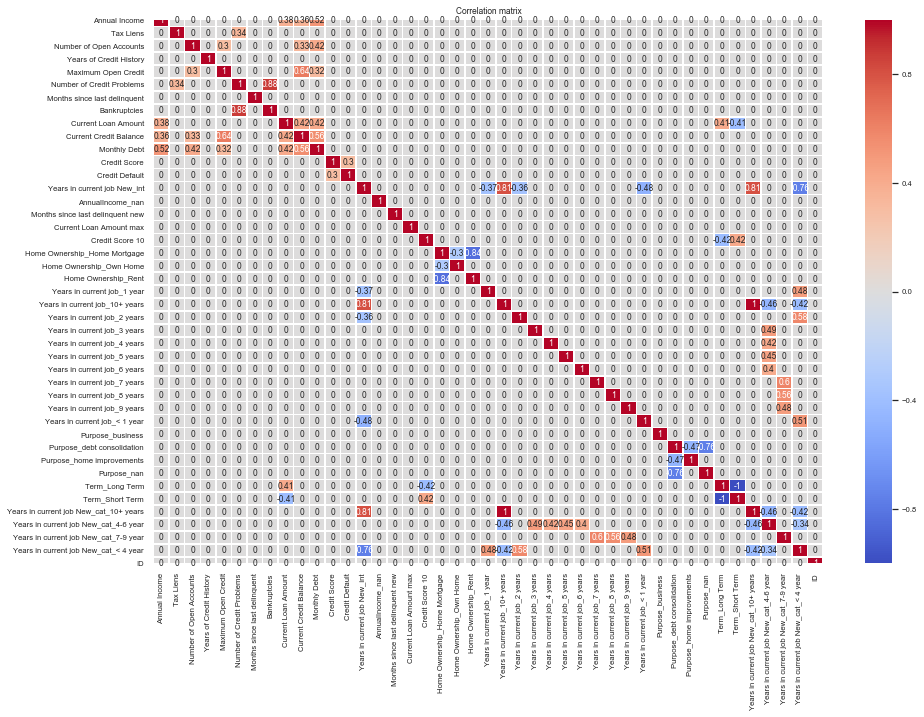

In [47]:
plt.figure(figsize = (15,10))

sns.set(font_scale=0.7)

corr_matrix = X.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0  
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

In [48]:
TARGET_NAME = 'Credit Default'
NUM_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 
                     'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 
                     'Months since last delinquent', 'Bankruptcies','Current Loan Amount', 
                     'Current Credit Balance', 'Monthly Debt', 'Credit Score', 
                     'Years in current job New_int', 'Credit Score 10']

CAT_FEATURE_NAMES = ['AnnualIncome_nan', 'Months since last delinquent new', 
                     'Current Loan Amount max', 'Years in current job_1 year', 
                     'Purpose_business', 'Purpose_debt consolidation', 
                     'Purpose_home improvements', 'Purpose_nan', 'Term_Long Term', 
                     'Term_Short Term', 'Years in current job New_cat_10+ years', 
                     'Years in current job New_cat_4-6 year', 'Years in current job New_cat_7-9 year', 
                     'Years in current job New_cat_< 4 year','Home Ownership_Home Mortgage',
                    'Home Ownership_Own Home','Home Ownership_Rent']

SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES

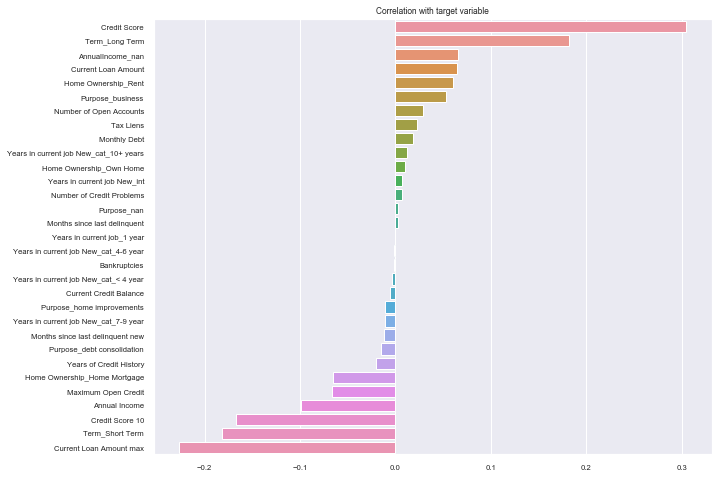

In [49]:
corr_with_target = X[NUM_FEATURE_NAMES + CAT_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

In [50]:
#Нормализация данных
scaler = StandardScaler()

df_norm = X.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

df = df_norm.copy()

In [51]:
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Purpose_debt consolidation,Purpose_home improvements,Purpose_nan,Term_Long Term,Term_Short Term,Years in current job New_cat_10+ years,Years in current job New_cat_4-6 year,Years in current job New_cat_7-9 year,Years in current job New_cat_< 4 year,ID
ID,,,,,,,,,,,,,,,,,,,,,
0,Own Home,-1.174592,10+ years,-0.134877,-0.024088,1.133645,0.022491,2.504893,-0.083484,2.842517,...,1,0,0,0,1,1,0,0,0,0
1,Own Home,-0.412651,10+ years,-0.134877,0.801797,-0.428528,0.625557,-0.399219,-0.083484,-0.351801,...,1,0,0,1,0,1,0,0,0,1
2,Home Mortgage,-0.796952,8 years,-0.134877,-0.024088,2.369181,0.626413,-0.399219,-0.083484,-0.351801,...,1,0,0,0,1,0,0,1,0,2
3,Own Home,-0.721716,6 years,-0.134877,-0.643502,0.593985,-0.632625,2.504893,-0.083484,2.842517,...,1,0,0,0,1,0,1,0,0,3
4,Rent,-0.762105,8 years,-0.134877,0.388854,-0.669954,-0.342586,2.504893,-0.083484,-0.351801,...,1,0,0,0,1,0,0,1,0,4


In [52]:
X = df[SELECTED_FEATURE_NAMES]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

In [53]:
df_norm = X_final.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

X_final = df_norm.copy()

In [54]:
#Балансировка целевой переменной

In [55]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    3771
1    2958
Name: Credit Default, dtype: int64

In [56]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

In [57]:
X_balanced = balance_df_by_target(df, TARGET_NAME)
X_balanced[TARGET_NAME].value_counts()

0    5387
1    4226
Name: Credit Default, dtype: int64

In [58]:
y_balanced = X_balanced[TARGET_NAME]
X_balanced = X_balanced.drop(columns=TARGET_NAME)

In [59]:
X_balanced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9613 entries, 3442 to 4630
Data columns (total 47 columns):
Home Ownership                            9613 non-null object
Annual Income                             9613 non-null float64
Years in current job                      9613 non-null object
Tax Liens                                 9613 non-null float64
Number of Open Accounts                   9613 non-null float64
Years of Credit History                   9613 non-null float64
Maximum Open Credit                       9613 non-null float64
Number of Credit Problems                 9613 non-null float64
Months since last delinquent              9613 non-null float64
Bankruptcies                              9613 non-null float64
Purpose                                   9613 non-null object
Term                                      9613 non-null object
Current Loan Amount                       9613 non-null float64
Current Credit Balance                    9613 non-null float6

Логистическая регрессия

In [60]:
model_lr = LogisticRegression(random_state=21)
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.70      0.83      0.76      3771
           1       0.71      0.54      0.62      2958

    accuracy                           0.70      6729
   macro avg       0.71      0.69      0.69      6729
weighted avg       0.71      0.70      0.70      6729

TEST

              precision    recall  f1-score   support

           0       0.81      0.82      0.81      1616
           1       0.52      0.51      0.52       634

    accuracy                           0.73      2250
   macro avg       0.67      0.66      0.67      2250
weighted avg       0.73      0.73      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1318  298
1                308  326


метод k средний дал ниже результат, чем логистическая и был удален

Бустинговые алгоритмы, сравним 2 метода

LightGBM

In [61]:
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      3771
           1       0.94      0.89      0.92      2958

    accuracy                           0.93      6729
   macro avg       0.93      0.93      0.93      6729
weighted avg       0.93      0.93      0.93      6729

TEST

              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1616
           1       0.54      0.47      0.50       634

    accuracy                           0.74      2250
   macro avg       0.67      0.65      0.66      2250
weighted avg       0.73      0.74      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1360  256
1                339  295


CatBoost

In [62]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.91      0.96      0.93      3771
           1       0.95      0.87      0.91      2958

    accuracy                           0.92      6729
   macro avg       0.93      0.92      0.92      6729
weighted avg       0.92      0.92      0.92      6729

TEST

              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1616
           1       0.56      0.46      0.51       634

    accuracy                           0.75      2250
   macro avg       0.68      0.66      0.67      2250
weighted avg       0.74      0.75      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1388  228
1                340  294


Подбор признаков

In [63]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

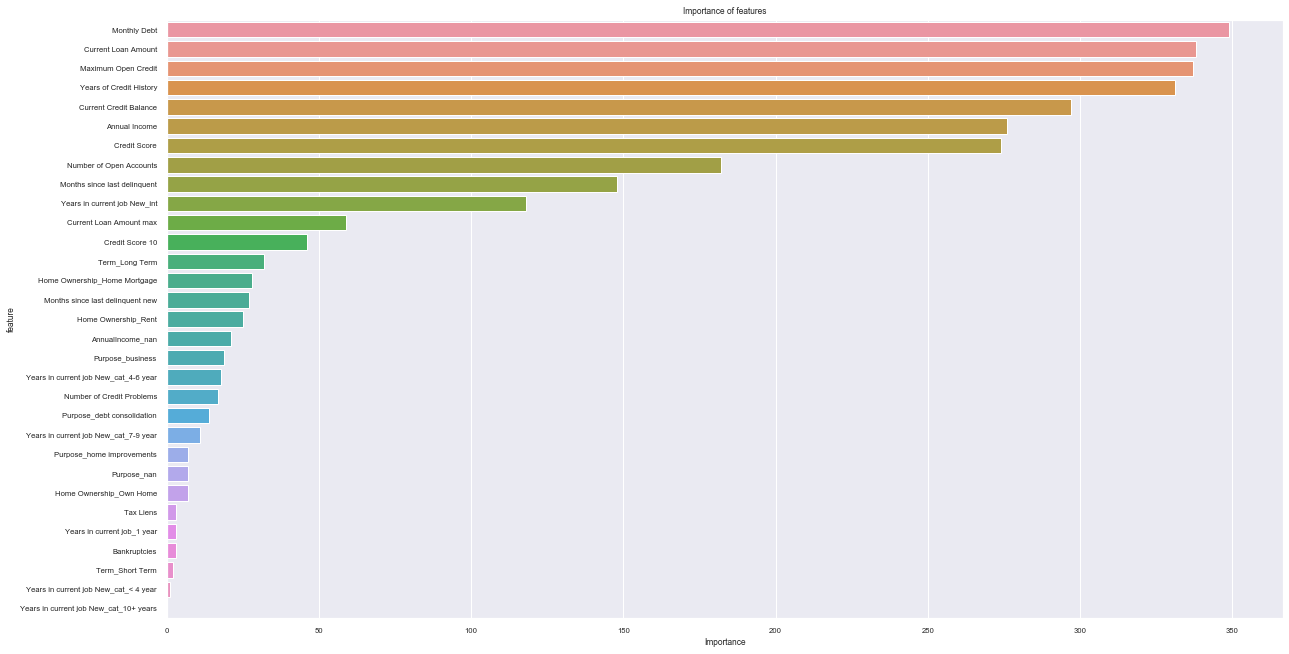

In [64]:
important_features_top = show_feature_importances(X_train.columns, model_lgbm.feature_importances_, get_top=15)

In [65]:
important_features_top

['Monthly Debt',
 'Current Loan Amount',
 'Maximum Open Credit',
 'Years of Credit History',
 'Current Credit Balance',
 'Annual Income',
 'Credit Score',
 'Number of Open Accounts',
 'Months since last delinquent',
 'Years in current job New_int',
 'Current Loan Amount max',
 'Credit Score 10',
 'Term_Long Term',
 'Home Ownership_Home Mortgage',
 'Months since last delinquent new']

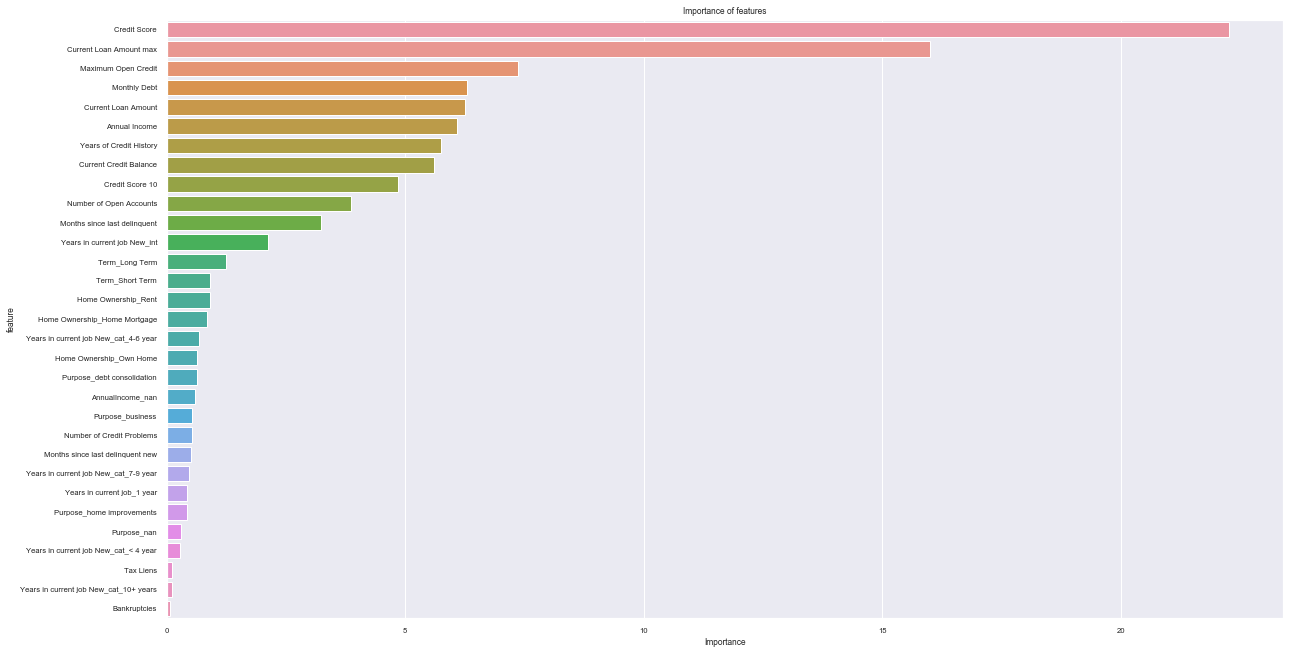

In [66]:
important_features_top = show_feature_importances(X_train.columns, model_catb.feature_importances_, get_top=15)

In [67]:
important_features_top

['Credit Score',
 'Current Loan Amount max',
 'Maximum Open Credit',
 'Monthly Debt',
 'Current Loan Amount',
 'Annual Income',
 'Years of Credit History',
 'Current Credit Balance',
 'Credit Score 10',
 'Number of Open Accounts',
 'Months since last delinquent',
 'Years in current job New_int',
 'Term_Long Term',
 'Term_Short Term',
 'Home Ownership_Rent']

видим, что топ 14 одинаковые, тогда оставим ТОП 15 model_catb и проверим, что качество не ухудшается

In [68]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train[important_features_top], y_train)

y_train_pred = model_catb.predict(X_train[important_features_top])
y_test_pred = model_catb.predict(X_test[important_features_top])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.90      0.96      0.92      3771
           1       0.94      0.86      0.90      2958

    accuracy                           0.91      6729
   macro avg       0.92      0.91      0.91      6729
weighted avg       0.91      0.91      0.91      6729

TEST

              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1616
           1       0.56      0.47      0.51       634

    accuracy                           0.75      2250
   macro avg       0.68      0.66      0.67      2250
weighted avg       0.74      0.75      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1380  236
1                334  300


качество не ухудшилось

поиск параметров для моделей LGBMClassifier и CatBoostClassifier не давал нужного результата, произходило переобучение, а на тесте 1 недооценены, штрафы и l2 почти не улучшали предсказания на тесте

In [69]:
model_catb = catb.CatBoostClassifier(n_estimators=200, l2_leaf_reg=3, 
                                     learning_rate=0.1, depth=7,
                                     class_weights=[1, 3.5], silent=True, random_state=21)
model_catb.fit(X_train[important_features_top], y_train)

y_train_pred = model_catb.predict(X_train[important_features_top])
y_test_pred = model_catb.predict(X_test[important_features_top])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      0.62      0.77      3771
           1       0.68      1.00      0.81      2958

    accuracy                           0.79      6729
   macro avg       0.84      0.81      0.79      6729
weighted avg       0.86      0.79      0.79      6729

TEST

              precision    recall  f1-score   support

           0       0.89      0.47      0.62      1616
           1       0.39      0.84      0.53       634

    accuracy                           0.58      2250
   macro avg       0.64      0.66      0.57      2250
weighted avg       0.74      0.58      0.59      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               765  851
1                99  535


поэтому остановимся на прослой логистической регрессии, но сдвинем порог до 0,48

In [70]:
model_lr = LogisticRegression(random_state=5)
model_lr.fit(X_train[important_features_top], y_train)

THRESHOLD = 0.48

y_train_pred = model_lr.predict(X_train[important_features_top])
y_test_pred = np.where(model_lr.predict_proba(X_test[important_features_top])[:,1] > THRESHOLD, 1, 0)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.69      0.84      0.76      3771
           1       0.71      0.52      0.60      2958

    accuracy                           0.70      6729
   macro avg       0.70      0.68      0.68      6729
weighted avg       0.70      0.70      0.69      6729

TEST

              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1616
           1       0.52      0.56      0.54       634

    accuracy                           0.73      2250
   macro avg       0.67      0.68      0.67      2250
weighted avg       0.73      0.73      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1285  331
1                281  353


In [71]:
model_lr = LogisticRegression(random_state=21)
model_lr.fit(X_balanced [important_features_top],y_balanced)

y_train_pred = model_lr.predict(X_balanced[important_features_top])
y_pred_proba = model_lr.predict(X_final[important_features_top])

THRESHOLD = 0.48

y_train_pred = model_lr.predict(X_balanced[important_features_top])
y_pred_final = np.where(model_lr.predict_proba(X_final[important_features_top])[:,1] > THRESHOLD, 1, 0)


In [72]:
preds_final = pd.DataFrame()
preds_final['ID'] = X_final.index
preds_final['Credit Default'] = y_pred_final
preds_final.head()

,ID,Credit Default
0,0,0
1,1,1
2,2,1
3,3,0
4,4,0


In [73]:
preds_final[TARGET_NAME].value_counts()

0    1809
1     691
Name: Credit Default, dtype: int64

Доля 1 в общих данных на тесте 38%, а в обучающем наборе данных 39%,что говорит о сохранении общей структуры, несмотря на балансировку. Ожидаемый F1 на предсказанных 1 в отрезке 0.52-0.54

In [74]:
preds_final.to_csv(r'C:\Users\Мила\Documents\Библиотеки Python для Data Science продолжение\course_project\LTsymbal_predictions.csv')